In [15]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline
import numpy as np
from matplotlib import pyplot as plt
from time import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
from interpolator import Interpolator


-----
# TMA4320 vår 2024 - Prosjekt i teknisk fysikk
 
I dag bor nesten førti prosent av verdenspopulasjonen innen hundre kilometer av kysten $^1$. Det vil si at nesten tre milliarder mennesker er direkte eller indirekte påvirket av havtilstandene. Og det tallet er kun forventet til å øke over de neste tiårene i takt med økende urbanisering. Dermed er det kritisk å forstå hvilken påvirkning havet har på oss og økosystemene rundt, men enda viktigere å forstå hvilken effekt vi har på havet.
En av de lettest observerbare menneskelige konsekvene på havet og dens økosystemer forekommer gjennom forsøpling, spesielt av plast. Plast ender opp i vannet gjennom utalige prosseser, men hovedsaklig via feilhåndtering av plast på land, tap av fiskeriutstyr og plast fra andre marine industrier. For å forstå slike prosseser er modeller og simuleringer av verden avgjørende.

Predaktive modeller av verden rundt oss er enromt relevante og kommer uten tvil til å bli viktigere fremover. Slike modeller spilte stor rolle i forståelsen av spredningen av olje i Deepwater Horizons katastrofen i 2010 $^2$, men modellene er essensielle, ikke kun med tanke på spredningen av miljøskadlig substanser som olje og plast. De kan være forskjellen mellom liv og død i redningsaksjoner etter ulykker på havet. De kan i tillegg gi oss innblikk i helsen til havøkosystemer ved å se på naturlige bevegelsen til plankton, algler og krill som er del av fundamentet til hele havets økosystem og er dermed vital i forståelsen av sjøen.

Formålet med denne oppgaven er å benytte predaktive modeller for simulere bevegelsen av plastikk i havet. Til dette formålet må ulike numeriske kalkulasjoner og ODE ligninger forståes og implementeres. Samtidig må data om vind og havstrømmer benyttes i kombinasjon med de matematiske metodene for å forutsi sannsynlig spredningen av plastavfall i havet. 

----
## Oppgave 1 - Et enkelt test tilfelle
### a)

In [16]:
def f_first(x: np.ndarray, t: np.ndarray, epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates function f used in velocity equation.
    :param x: array
    :param t: array
    :param epsilon: float
    :param w: float
    return array
    """""
    return epsilon*np.sin(w*t)*x**2 + (1-2*epsilon*np.sin(w*t))*x #implementert a(t) og b(t) i f(x,t)

def del_f(x: np.ndarray, t: np.ndarray ,epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates function f used in velocity equation.
    :param x: np.ndarray
    :param t: np.ndarray
    :param epsilon: float
    :param w: float
    return np.ndarray
    """""
    return epsilon*np.sin(w*t)*2*x + (1-2*epsilon*np.sin(w*t))

def velocity_x(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates velocity in x direction.
    :param x: np.ndarray
    :param y: np.ndarray
    :param t: np.ndarray
    :param A: float
    :param epsilon: float
    :param w: float
    return np.ndarray
    """""
    return -np.pi*A*np.sin(np.pi*f_first(x,t, epsilon, w))*np.cos(np.pi*y)

def velocity_y(x: np.ndarray, y: np.ndarray, t: np.ndarray , A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function calculates velocity in y direction.
    :param x: np.ndarray
    :param y: np.ndarray
    :param t: np.ndarray
    :param A: float
    :param epsilon: float
    :param w: float
    return np.ndarray
    """""
    return np.pi*A*np.cos(np.pi*f_first(x,t, epsilon, w))*np.sin(np.pi*y)*del_f(x,t, epsilon, w)

def Heun(init_pos: tuple, t_end: int, h: float, A: float, epsilon: float, w: float) -> np.ndarray:
    """""
    function uses the Heun integrate method to calculate the next position for the particle
    :param init_pos: tuple
    :param t_end: int
    :param h: float
    :param A: float
    :param epsilon: float
    :param w: float
    return np.ndarray
    """""
    num_particles = init_pos.shape[2]
    
    t = 0
    steps = int(t_end / h)
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = init_pos

    for i in range(steps):
        k_1_x = velocity_x(x[i, 0, :], x[i, 1, :], t, A, epsilon, w)
        k_1_y = velocity_y(x[i, 0, :], x[i, 1, :], t, A, epsilon, w)

        k_2_x = velocity_x(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, t+h , A, epsilon, w)
        k_2_y = velocity_y(x[i, 0, :] + k_1_x * h, x[i, 1, :] + k_1_y * h, t+h , A, epsilon, w)

        x_add_x = x[i, 0, :] + (h / 2) * (k_1_x + k_2_x)
        x_add_y = x[i, 1, :] + (h / 2) * (k_1_y + k_2_y)

        x[i + 1, 0, :] = x_add_x
        x[i + 1, 1, :] = x_add_y
        t += h
    return x

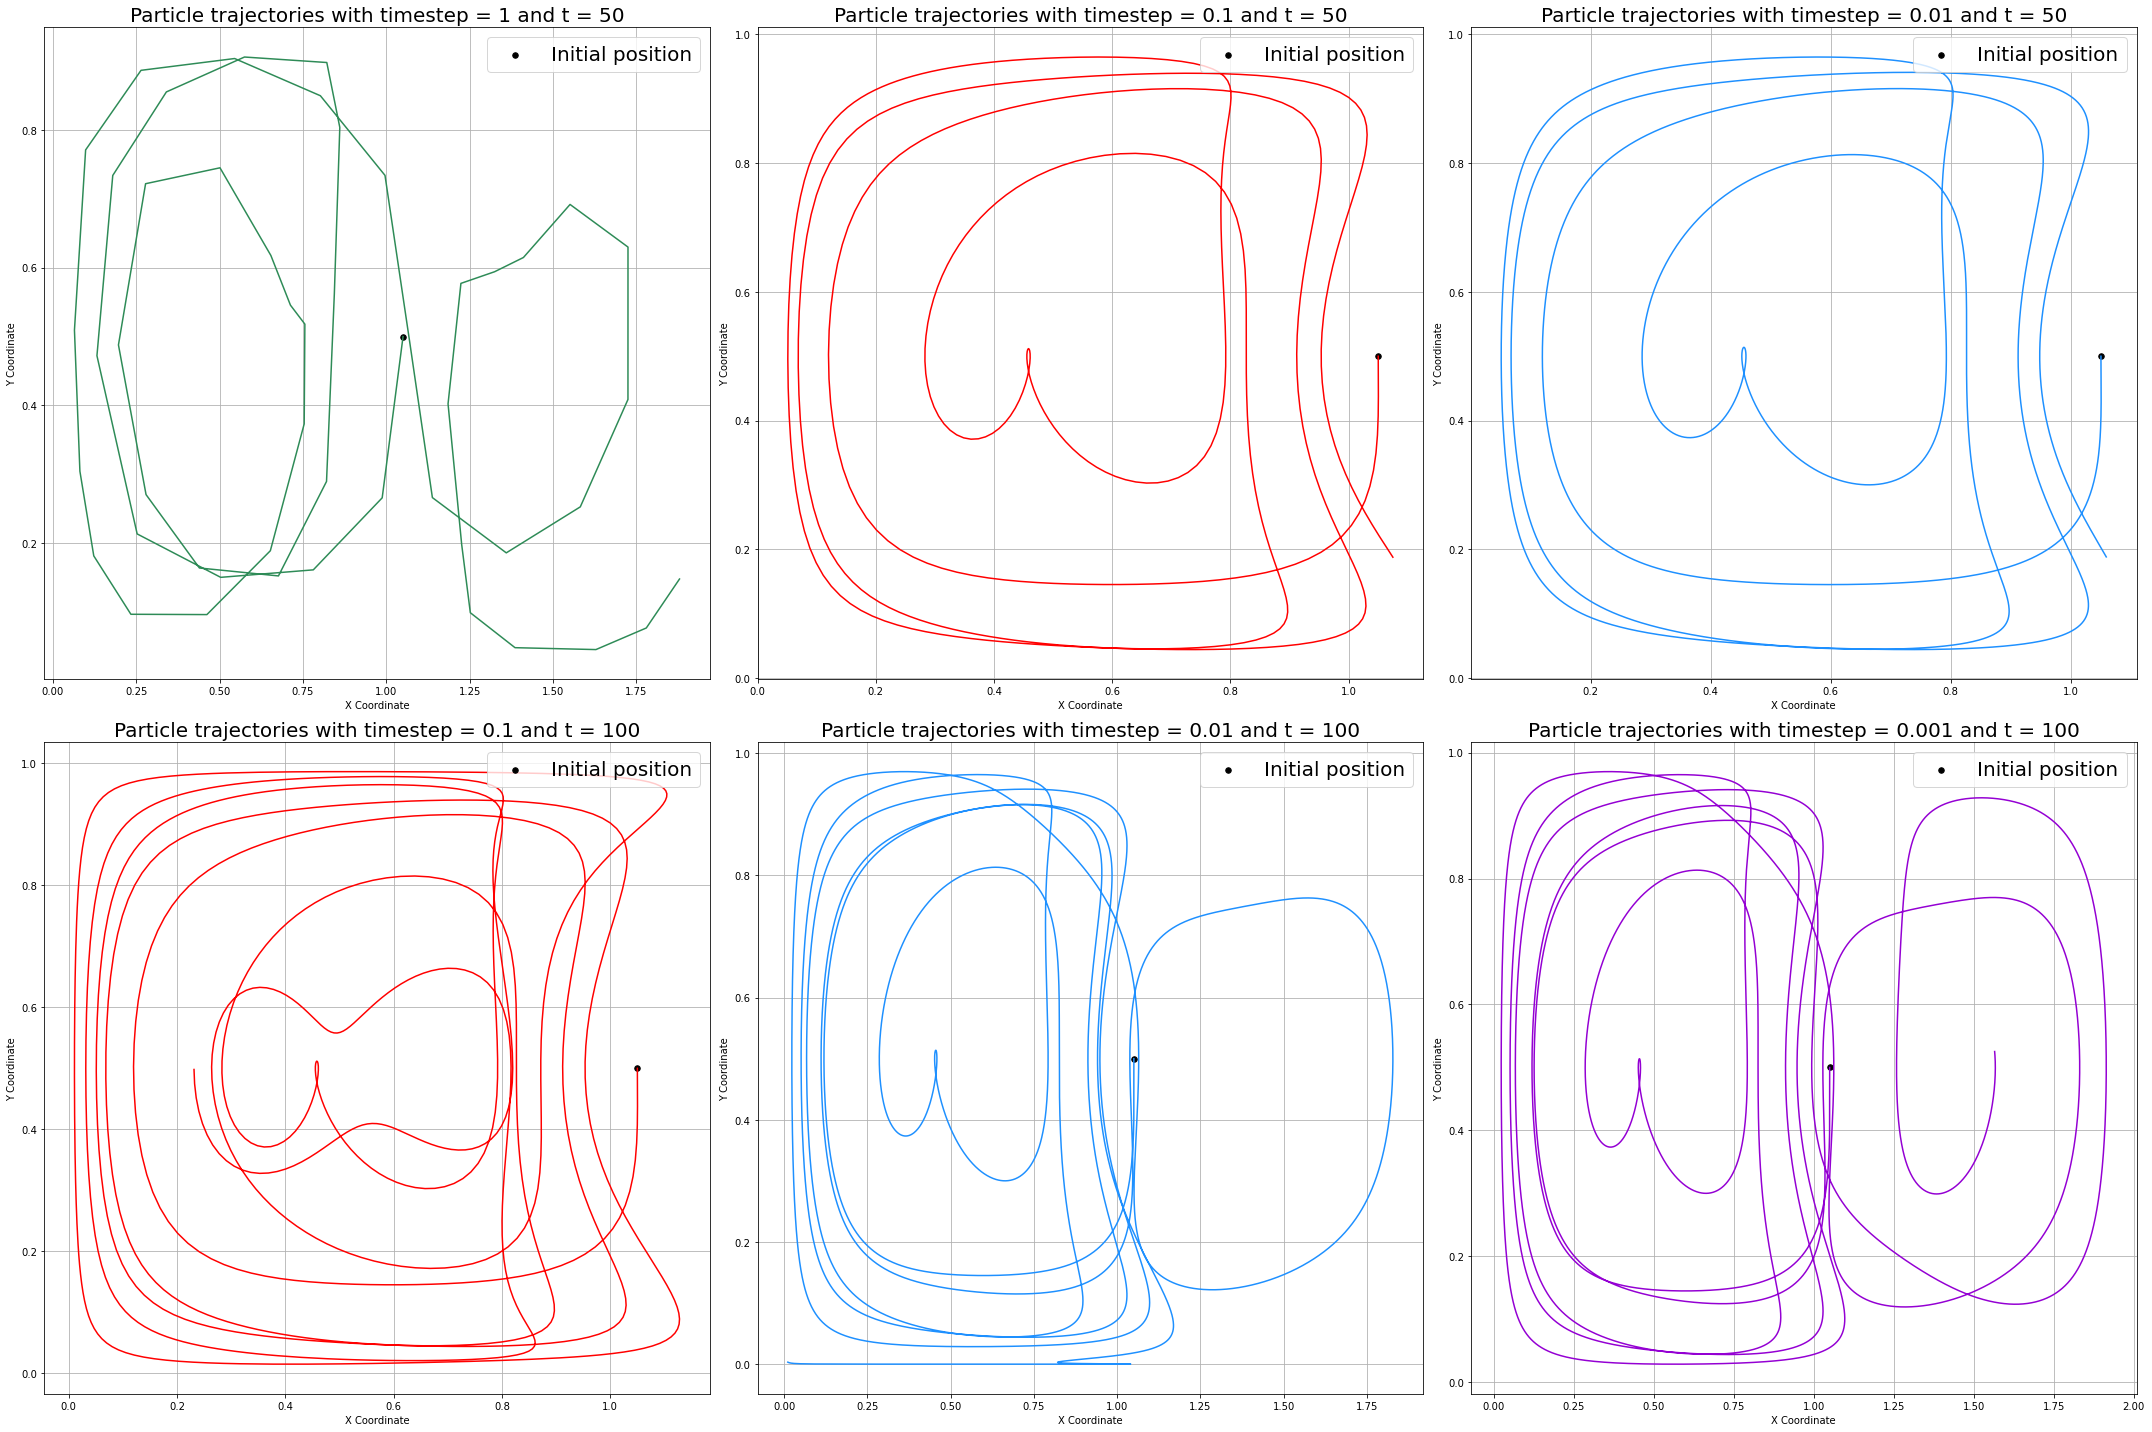

In [17]:
#plotter bevegelsen til partikkel ved hjelp av Heun metode, med gitte initialverdier og konstanter
A = 0.1
epsilon = 0.25
w = 1
init_pos = np.array([[[1.05, 0.5]]]).reshape(1,2,1) #startposisjon, grunnen til reshape er fordi Heun tar inn batches
t = 50
h = [1, 0.1, 0.01]
cmaps = [plt.get_cmap('Blues'), plt.get_cmap('Greens'), plt.get_cmap('Reds')]
fig, axs =plt.subplots(2,3, figsize = (30,20))
colors = ['seagreen', 'red', 'dodgerblue', 'darkviolet']
for i in range(len(h)):    
    positions = Heun(init_pos, t, h[i], A, epsilon, w) #gir array med posisjon for partikkelen
    num_pos = positions.shape[0]
    axs[0,i].plot(positions[:,0, :], positions[:,1, :] , color = colors[i])
    axs[0,i].set_xlabel('X Coordinate', fontsize = 10)
    axs[0,i].set_ylabel('Y Coordinate', fontsize = 10)
    axs[0,i].set_title(f'Particle trajectories with timestep = {h[i]} and t = {t}', fontsize = 20)
    axs[0,i].scatter(init_pos[:,0,:], init_pos[:,1,:], label = f'Initial position', color = 'black', s = 30)
    axs[0,i].legend(loc = 1, fontsize = 20)
    axs[0,i].grid(True)
t = 100
h = [0.1, 0.01, 0.001]
for i in range(len(h)):    
    positions = Heun(init_pos, t, h[i], A, epsilon, w) #gir array med posisjon for partikkelen
    num_pos = positions.shape[0]
    axs[1,i].plot(positions[:,0, :], positions[:,1, :] , color = colors[i+1])
    axs[1,i].set_xlabel('X Coordinate', fontsize = 10)
    axs[1,i].set_ylabel('Y Coordinate', fontsize = 10)
    axs[1,i].set_title(f'Particle trajectories with timestep = {h[i]} and t = {t}', fontsize = 20)
    axs[1,i].scatter(init_pos[:,0,:], init_pos[:,1,:], label = f'Initial position', color = 'black', s = 30)
    axs[1,i].legend(loc = 1, fontsize = 20)
    axs[1,i].grid(True)
plt.tight_layout()
plt.show()

Plottene over tar for seg en analytisk tilnærming av hastighetsfelt for å se på partikler som beveger seg. Den analytiske tilnærmingen beskriver en ODE som består av $\dot{x} = [v_x(\textbf{x},t),v_y(\textbf{x},t)]$ hvor henholdsvis hastighetsfeltet i x - retning er beskrevet av $v_x = - \pi  A sin(\pi f(x,t)) cos(\pi y ) $ og i y - retning $v_y = \pi A \pi  A cos(\pi f(x,t)) sin(\pi y ) \frac{\partial f(x,t)}{\partial x} $ begge disse hastighetselftene består av enda en funksjon $f(x,t)$, som gir posisjon og tidsavhengighet til hastighetsfeltene. Det er noen gitte konstanter som; $A, \epsilon, \omega $, hensikten med disse er å justere hastighetsfeltet i systemet. 

Måten det er løst på i denne oppgaven er at det blir brukt 3d - array av shape (steg, koordinater, antall partikler). Dette er hensiktsmessig for da slipper man bruken av enda en variabel for tid, og operasjonen blir betraktelig raskere. Som grafisk vist ovenfor er det en partikkel i dette hastighetsfeltet med ulig steglengde og ulik integrasjonstid. Ved studering av integrasjonstid lik $50$ ser man liten forskjell, omså ingen på steglengde $0.1$ og $0.01$, så det som ville vært hensiktsmessig å gå videre med utifra den informasjonen blir $h = 0.1$. Den numeriske operasjonen vil være raskere og tilstrekkelig lik bevegelsen til en partikkel med $10^1$ flere steg.
Steglengden h = 1 blir såpass "hakkete" på integrasjonstid $50$ at å vurdere den videre er ugunsting, dermed erstattes den med steglengde $0.001$.

På plottet med integrasjonstid lik $100$ under derimot ser man stor forskjell på steglengde 0.1 og 0.01. Forskjellen blir så stor at det ikke vil være logsik å gå videre med steglengde 0.1 fordi mye informasjon om partiklens bevegelse vil gå tapt. Forskjellen for steglengde $h = 0.01$ og $0.001$ er minimal men man ser mot slutten av banen er det et lite avvik. Altså mot slutten av integrasjonstid = 100 ser man en liten forskjell, så gående videre i oppgaven vil h = $0.001$ taes i bruk, ved antagelse og bekreftelse på at kjøretid ikke blir et problem.

Forskjellen som oppstår i mellom bevegelsen ved h = $0.01$ og $0.001$ er ingenting før man nærmer seg slutten av integrasjonstiden, så med minsket integrasjonstid vil nok ikke forskjellen bli tydlig i mellom de to steglengdene. Selv med tanke på dette er det ikke ønskelig med "tap" av informasjon, så uansett vil h = $0.001$ bli tatt i bruk


## b)

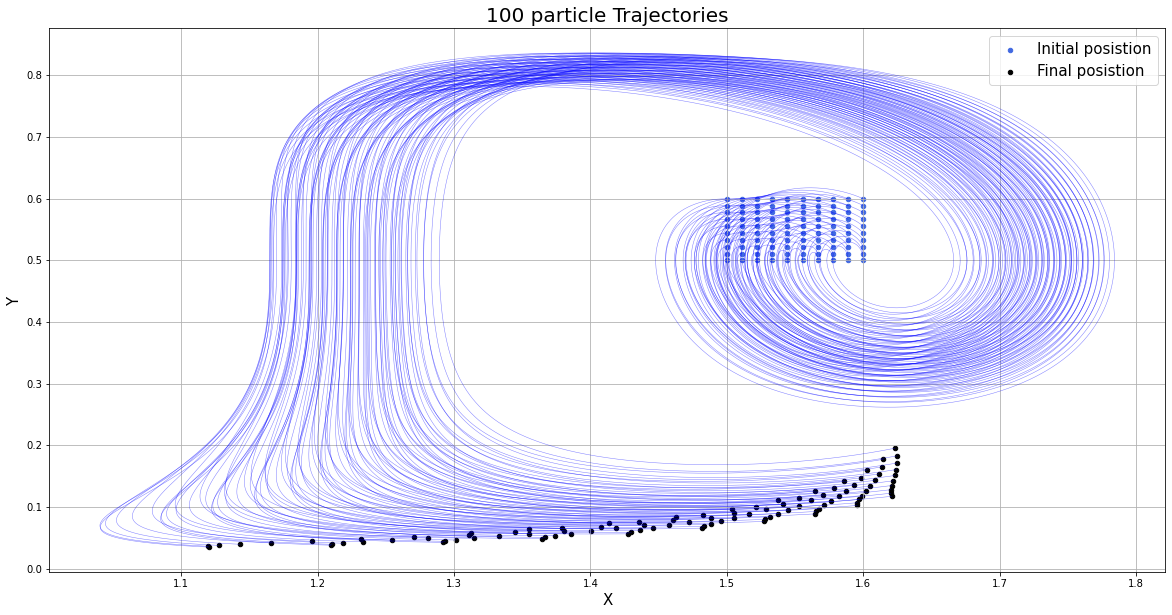

In [18]:
N_p = 100
t = 10
A = 0.1
epsilon = 0.25
w = 1
h = 0.001
num_points = int(N_p / 10)

# Creating a grid of initial positions
x_cor = np.linspace(1.5, 1.6, num_points)
y_cor = np.linspace(0.5, 0.6, num_points)
x_grid, y_grid = np.meshgrid(x_cor, y_cor) 
init_pos = np.stack((x_grid, y_grid)) # Creates a grid with evenly spaced points in a 0.1 x 0.1 grid
init_pos = init_pos.reshape(1, 2, -1)

positions = Heun(init_pos, t, h, A, epsilon, w)

# Plotting the trajectories of the particles
plt.figure(figsize = (20,10))
plt.scatter(positions[0,0,:], positions[0,1,:], label = "Initial posistion", color = 'royalblue', s = 20)
plt.scatter(positions[-1,0,:], positions[-1,1,:], label = "Final posistion", color = "black", s = 20)
plt.plot(positions[:, 0, :], positions[:, 1, :],color = 'blue',  alpha=0.5, lw=0.5)
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.title('100 particle Trajectories', fontsize = 20)
plt.legend(loc = 1, fontsize = 15)
plt.grid(True)
plt.show()

In [19]:
snitt_avstand_0 = np.round(np.mean(np.diff(positions[0, :, :])), 4)
snitt_avstand = np.round(np.mean(np.diff(positions[-1, :, :])), 4)
minste_avstand = np.round(np.min(abs(np.diff(positions[-1, :, :]))),7)
lengste_avstand = np.round(np.sqrt( (np.max(positions[-1, 1, :])-np.min(positions[-1, 1, :]))**2+(np.max(positions[-1, 0, :])-np.min(positions[-1, 0, :]))**2),4)
print(f'Avstand mellom per partikkel ved start: {snitt_avstand_0} \nAvstand mellom per partikkel ved slutt: {snitt_avstand}')

print(f'Minste avstand ved slutttilstand: {minste_avstand} \nLengste avstand ved slutttilstand {lengste_avstand}')

Avstand mellom per partikkel ved start: 0.001 
Avstand mellom per partikkel ved slutt: 0.0016
Minste avstand ved slutttilstand: 4.77e-05 
Lengste avstand ved slutttilstand 0.53


Som sagt i oppgave 1a) har steglengde $h = 0.001$ blitt tatt i bruk. Startposisjon er en grid i $0.1 \times 0.1$ størrelse tatt i bruk, ved 100 partikler blir det altså tilnærmet 0.001 avstand mellom hver partikkel ved start. Som printet over ser vi at gjennomsnittlig avstand ved slutten er tilnærmet 0.0016, altså en en forskjell i 0.0006, som ikke virker spesielt mye. Men ved å studere plottet ser sluttposisjonen mer kaotisk ut enn den perfekte grid plasseringen i start, grunnen til at avstanden ikke er større i sluttposisjon er fordi beregningene tar gjennomsnittlig avstand. Som også printet vises minste og lengste avstand, som man ser er minste avstand i sluttposisjon mindre enn avstanden i mellom hver partikkel i startposisjon.
Dette forklares veldig enkelt med at ulike partikler i ulike startposisjoner vil oppleve ulike styrker fra vektorfeltet, vektorfeltet holder seg ikke konstant hverken i en gitt plass eller ved et gitt tidspunkt. Så en partikkel som går gjennom punkt $a$ ved en tid vil oppleve ulik styrke enn partikkel $b$ i samme punkt ved en annen tid. Noe vi ser tydelig på plottet for 100 partiklers bevegelser.

## c)

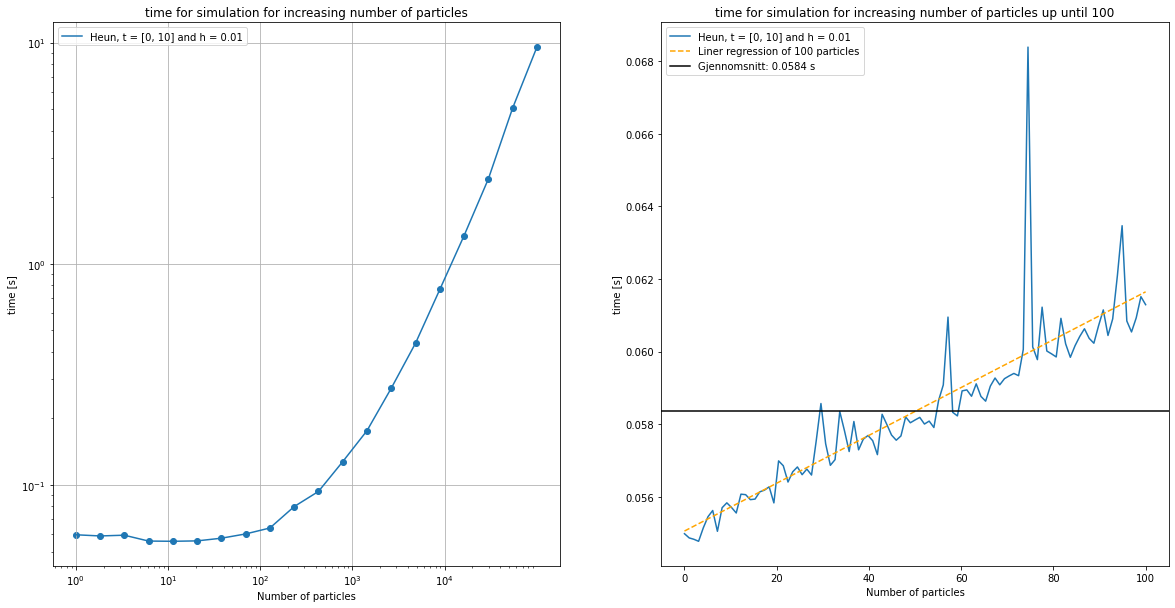

In [20]:
#N_p = np.concatenate([np.linspace(1,90,10) ,np.linspace(100,900,7), np.linspace(1000,8000,5) ,np.linspace(10000,100000,3)])
N_p = np.logspace(0,5, 20)
N_p2 = 100
h = 0.01
t = 10
time_list = []
time_list2 = []
i = 1
# Testing Heun for up N_p amount of particles, with 3ˆn intervals
for i in N_p:
    ones= np.ones(int(i))
    init_pos = np.array([[ones*1.05, ones*0.5]])
    start = time()
    Heun(np.array(init_pos), t, h, A, epsilon, w)
    end = time()
    time_list.append(end-start)

# Testing Heun for all particle amounts up to N_p2
for i in range(1,N_p2):
    ones= np.ones(i)
    init_pos = np.array([[ones*1.05, ones*0.5]])
    start = time()
    Heun(np.array(init_pos), t, h,A, epsilon, w)
    end = time()
    time_list2.append(end-start)

# Linear regression
lin_reg_10000 = np.polyval(np.polyfit(np.linspace(0, N_p[-1], len(time_list)), time_list, deg=1), np.linspace(0, N_p[-1], len(time_list)))
lin_reg_100 = np.polyval(np.polyfit(np.linspace(0, N_p2, len(time_list2)), time_list2, deg=1), np.linspace(0, N_p2, len(time_list2)))


# Ploting of simulations
fig, axs =plt.subplots(1,2, figsize = (20,10))

axs[0].plot(N_p, time_list, label = "Heun, t = [0, 10] and h = 0.01")
axs[0].scatter(N_p, time_list)
#axs[0].plot(np.linspace(0, N_p, len(time_list)), lin_reg_10000, linestyle="dashed", label= "Liner regression of 10000 particles", color = "orange")
axs[0].set_xlabel("Number of particles")
axs[0].set_ylabel("time [s]")
axs[0].set_title("time for simulation for increasing number of particles")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xticks([1,10,100,1000,10000])
axs[0].grid(True)
axs[0].legend(loc = 2)


axs[1].plot(np.linspace(0, N_p2, len(time_list2)), time_list2, label = "Heun, t = [0, 10] and h = 0.01")
axs[1].plot(np.linspace(0, N_p2, len(time_list2)), lin_reg_100, linestyle="dashed", label= "Liner regression of 100 particles", color = "orange")
axs[1].axhline(np.mean(time_list2), color = 'black', label = f'Gjennomsnitt: {np.round(np.mean(time_list2),4)} s')
axs[1].set_xlabel("Number of particles")
axs[1].set_ylabel("time [s]")
axs[1].set_title("time for simulation for increasing number of particles up until 100")
axs[1].legend(loc = 2)
plt.show()


Figurene over viser kjøretiden programmet bruker på Heun's metode for et økende antall partikler, figuren til venstre er på logaritmisk skala og tar partikler i $N_P = 10^x$ med $x \in [0,1,2,3,4,5]$. I tilegg er en linær regresjon lagt ved for å vise tydelig økningen til tiden. Figuren til høyre ser på partikler fra $1 \rightarrow 100$ og er tilført en rett strek for gjennomsnittsverdien til tiden, i tilegg er en lineær regresjon lagt ved for å vise at utviklingen med økende partikler holder seg rundt denne snitttid.

vi ser tydelig antydning til konstante verdier for lavere antall parikkler, til og med helt opp til $10^2$ partikler. Selv om det ved tilfeller av simulering kommer større standardavvik i fra den gjennomsnittsverdien ser vi at de alle flukserer rund en konstant verdi, grunnen til dette kommer trolig fra numerisk unøyaktigheter. Som nevnt tidligere håndterer vi dataen som et 3d - array i form av (steg, koordinater, antall partikler), når steg blir $\frac{integrasjonstid}{tidssteg}$ som med $t = 10$ og $h = 0.01$ danner et array med størrelse $(1001, 2, N_p)$ ($1001$ inkludert startbetingelser), med antall partikler holdt lavt vil den matematiske operasjonen kreve tilnærmet likt fordi batchstørrelsen blir stor i forhold. Antall partikler vil dermed ikke kreve mer fordi det blir neglisjerbart i forhold til batch-størrelsen. Når antall partikler blir større enn batchstørrelsen blir det en klar økning i tid som sett på figuren til venstre.

# Oppgave 2 - Transport av partikkel med sjøstrømmer

## a og b)
Nevn stipulasjoner

In [21]:
def Heun_2(X: np.ndarray, days: int, h: int, f):
    t_end = days * 24 * h
    steps = int(t_end / h)
    num_particles = X.shape[1]
    x = np.empty((steps + 1, 2, num_particles))
    x[:, :, :] = X
    t = 0
    for i in range(steps):
        k_1 = f(X, t)
        k_2 = f(X + h * k_1, t + h)
        X_next = (X + (h / 2) * (k_1 + k_2)).reshape(1, 2, num_particles)
        X = X_next[-1, :, :]
        x[i + 1, :, :] = X
        t += h
    return x


def distance_traveled(x: np.ndarray):
    distance_arr = np.zeros(x.shape[2])

    for i in range(x.shape[2]):
        diff_NS = np.diff(x[:, 0, i])
        diff_WE = np.diff(x[:, 1, i])

        distance = np.sum(np.sqrt(diff_NS**2 + diff_WE**2))
        distance_arr[i] = distance
    
    return np.mean(distance_arr), np.max(distance_arr) 

def max_spread(x: np.ndarray):
    x_reshaped = x[-1, :, :]
    spread_distance = np.linalg.norm(x_reshaped[:, :, np.newaxis] - x_reshaped[:, np.newaxis, :], axis=0)
    max_spread_distance = np.max(spread_distance)

    return max_spread_distance

In [33]:
file_path = "NorKyst-800m.nc"

d = xr.open_dataset(file_path)

f  = Interpolator(dataset = d)

h = 3600
days = 5
Np = 1000

X_1 = np.zeros((2,Np))
X_1[0,:] = np.random.normal(loc = 790000, scale=10000, size = Np)
X_1[1,:] = np.random.normal(loc = 490000, scale=10000, size = Np)

X_2 = np.zeros((2, Np))
X_2[0,:] = np.random.normal(loc = 1240000, scale=10000, size = Np)
X_2[1,:] = np.random.normal(loc = 480000, scale=10000, size = Np)

position_trondheim = Heun_2(X_1, days, h, f)
f  = Interpolator(dataset = d)
position_lofoten = Heun_2(X_2, days, h, f)


avg_dis_tro, max_dis_tro = distance_traveled(position_trondheim)
avg_dis_lof, max_dis_lof = distance_traveled(position_lofoten)
max_spread_tro = max_spread(position_trondheim)
max_spread_lof = max_spread(position_lofoten)

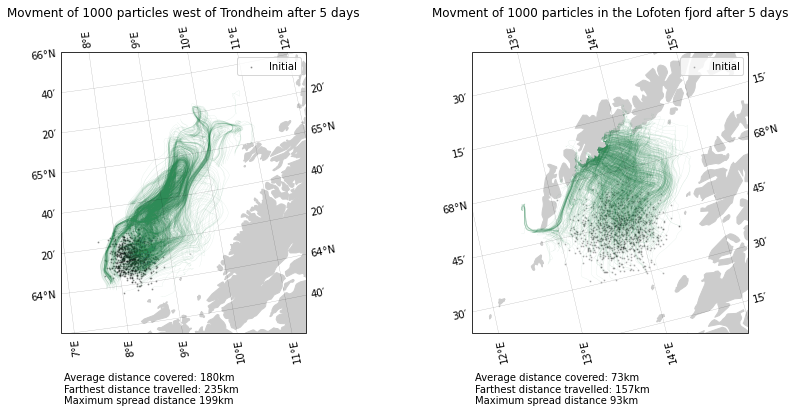

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Create projection object for converting particle positions
npstere = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting=f.dataset.projection_stere.false_easting,
    false_northing=f.dataset.projection_stere.false_northing,
    true_scale_latitude=f.dataset.projection_stere.standard_parallel,
)

# Plot position_trondheim
axs[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
axs[0].scatter(position_trondheim[0, 0, :], position_trondheim[0, 1, :], s=1, transform=npstere, label='Initial', color = 'black', alpha=.3)
axs[0].plot(position_trondheim[:, 0, :], position_trondheim[:, 1, :], transform=npstere, alpha=0.2, lw=0.2, color = 'seagreen')
axs[0].set_extent(axs[0].get_extent(crs = ccrs.PlateCarree()), crs = ccrs.PlateCarree())
axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.3, color='k', lw=.3)
axs[0].set_title(f"Movment of {Np} particles west of Trondheim after {days} days")
axs[0].text(0.01, -0.25, f'Average distance covered: {int(avg_dis_tro/1000)}km\nFarthest distance travelled: {int(max_dis_tro/1000)}km\nMaximum spread distance {int(max_spread_tro/1000)}km',
             transform=axs[0].transAxes, ha='left')
axs[0].legend()

# Plot position_lofoten
axs[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
axs[1].scatter(position_lofoten[0, 0, :], position_lofoten[0, 1, :], s=1, transform=npstere, label='Initial', color = 'black', alpha=.2)
axs[1].plot(position_lofoten[:, 0, :], position_lofoten[:, 1, :], transform=npstere, alpha=0.2, lw=0.2, color = 'seagreen')
axs[1].set_extent(axs[1].get_extent(crs = ccrs.PlateCarree()), crs = ccrs.PlateCarree())
axs[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.3, color='k', lw=.3)
axs[1].set_title(f"Movment of {Np} particles in the Lofoten fjord after {days} days")
axs[1].text(0.01, -0.25, f'Average distance covered: {int(avg_dis_lof/1000)}km\nFarthest distance travelled: {int(max_dis_lof/1000)}km\nMaximum spread distance {int(max_spread_lof/1000)}km',
             transform=axs[1].transAxes, ha='left')
axs[1].legend()


plt.tight_layout()
plt.show()


I figurene over er det plottet bevegelsen av numeriske representasjoner av plast i havet. Med numerisk representasjon menes det at hver partikkel ikke representer individuelle plastikkpartikler, men heller en masse av ulike plastikkpartikler. Denne bevegelsen er kalkulert ved bruk Huens metode, som tidligere beskrevet i oppgave 1, sammen med data om vær, vind og havtilstander, som havstrømmer. Dette er den preparerte datafilen gitt i oppgaven $^2$, hentet fra Norkyst.
Dataen inneholder 6 dager med vind og havstrøm data som spenner fra 20 til 25 mars 2024. Tidsdimensjonen i filen er gitt i sekunder, men det er kun ny data hver time. Dette er grunnen til at $h = 3600$ blir benyttet slik at hvert huen steg kan gjøres med faktisk observert data, og ikke en interpolering av data mellom tidspunktene.
Samtidig må det gjøres en interpolering av dataen geografisk ettersom datafilen har en oppløsning på $800\times800$ m. For å bedre simulere bevegelsen av partiklene brukes spline interpolering slik at det er et kontinuerlig vektorfelt mellom to ulike punkter.

Over er den simulerte bevegelsen av 1000 tilfeldig plasserte partikler, innenfor et område på $10\times10$ km, etter 5 dager.
Den venstre figuren viser partikler plassert i området vest for Trondheim, og figuren til høyre viser bevegelsen av plast i Lofoten fjorden. Antall partikler, $N_p$, er satt til $1000$. Dette antallet ble valgt ettersom det å øke partikelmengden ikke gir mer informasjon, men heller gjør figuren mindre oversiktlig. Dette er hovedgrunnen til antallet valgt, selv om færre partikler også vil minke simuleringstiden, men dette er ikke tatt hensyn til ettersom kjøretiden allerede er svært lav.

Lokasjonene til figurene gir innblikk i ulike tilstander som finnes langs den norskekysten. Utenfor Trondheim er det mer åpent hav med sterke vinder og liten påvirkning av geografiske trekk som land. I kontrast til dette gjøres den andre simuleringen av plast i Lofoten fjorden, hvor partiklene er mer skjermet fra vinden og havstrømmene påvirkes av de mange nærliggende landmassene. Samtidig er Lofoten en del av Norges naturarv, og derfor er det spesielt viktig å forstå hvilken påvirkning plast kan ha i dette området.

Under figurene er det ytterligere informasjon om partikkelbevegelsen til plastikken. Både gjennomsnitts avstanden og den maximale avstanden til de ulike partiklene er oppgitt under diagrammene etter område. Funksjonen som returner disse verdiene fungerer ved å bruke posisjonene til hver partikkel, og finner lengden en gitt partikkel beveger seg på en time. Den siste verdien er den maksimale spreadningen mellom partikler i sluttposisjonen. Den gjør dette ved å bruke linær algebra for å finne den parvise avstanden mellom alle partiklene og returnerer den største. Fra det kan en se at fra start til slutt har spreadningen til partiklene økt enormt fra 10km.
Denne informasjonen gir en bedre forståelse av distansen slike partikler kan bevege seg over bare 5 dager. På åpent havet, som vest for Trondheim, er det vanlig at partikler kan bevege seg mer enn 150km på 5 dager. Det tilsier en fart på om lag 1.3km/t. Med den farten kan plast fra Sør-Norge nå områder i Nord-Norge på 40 dager. Inni Lofoten fjorden beveger partiklene seg intuitivt kortere over samme periode, på grunn av lavere vindhastigheter nærmere land. Likevel er observasjonen klar, plast kan påvirke økosystemer som ligger store avstander unna opprinnelse punktet til partiklene. 
Dette er også nyttig i henhold til å vite om resultatene er troverdige. Havstrømmer i Norskehavet kan bevege seg opp mot 25km per dag. I tillegg er dataen fra en periode med sterk vind vest for Norge. Da bør bevegelsen av partikkelene være mer enn 125km i løpet av 5 dager, og det stemmer overens med de kalkulerte avstandene.


# Oppgave 3 - Stranding av partikkler


## a)

In [24]:
def Heun_3(X: np.ndarray, days: int, h: int, f: Interpolator) -> np.ndarray:
    """
    Function that calculates the movement of particles using the Heun method.
    :param X: np.ndarray
    :param days: int
    :param h: int
    :param f: Interpolator
    :return: np.ndarray
    """

    t_end = days*24*h
    t = 0
    steps = int(t_end / h)
    num_particles = X.shape[1]
    x = np.empty((steps + 1, 2, num_particles))
    x[0, :, :] = X
    for i in range(0,steps):
        k_1 = f(X, t)
        k_2 = (f(X+ k_1*h,t + h))
        
        on_land = f.on_land(X.reshape(2, num_particles))
        on_land = np.where(on_land, 0, 1)
        on_land = np.array([on_land, on_land]).reshape(1,2, num_particles)
        
        X_next = (X + (h / 2) * (k_1 + k_2)*on_land).reshape(1,2,num_particles)
        X = X_next[-1,:,:]
        x[i + 1, :, :] = X
        t += h
    return x

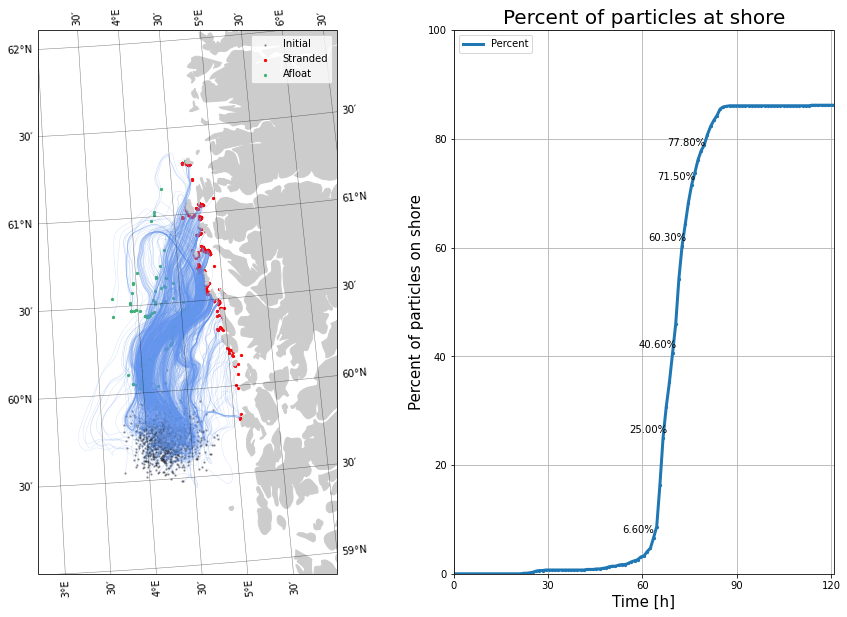

In [25]:
file_path = "NorKyst-800m.nc"
d = xr.open_dataset(file_path)

h = 3600
days = 5
Np = 1000

# Vestland
f_vestland = Interpolator(dataset = d)
X_4 = np.zeros((2,Np))
X_4[0,:] = np.random.normal(loc = 250000, scale=10000, size = Np)
X_4[1,:] = np.random.normal(loc = 460000, scale=10000, size = Np)
posi_vestland = Heun_3(X_4, days, h, f_vestland)

# Plotting the trajectories of the particles
fig, axs = plt.subplots(1,2, figsize=(15, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axs[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
axs[0].scatter(posi_vestland[0, 0, :], posi_vestland[0, 1, :], s=2, color = 'black', transform=npstere, label='Initial', alpha = 0.3)
on_land = f.on_land(posi_vestland[-1,:,:])
axs[0].scatter(posi_vestland[-1, 0, :]*on_land, posi_vestland[-1, 1, :]*on_land, color = 'red', s=5, transform=npstere, label='Stranded')
axs[0].scatter(posi_vestland[-1, 0, :]*~on_land, posi_vestland[-1, 1, :]*~on_land, color = 'mediumseagreen', s=5, transform=npstere, label='Afloat')
axs[0].plot(posi_vestland[:, 0, :], posi_vestland[:, 1, :], transform=npstere, color = 'cornflowerblue',  alpha=0.4, lw=0.3)
extent = axs[0].get_extent(ccrs.PlateCarree())
axs[0].set_extent((3,6,59, 62))
axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
# axs[i // 2, i % 2].set_title(f'Movemenent with windage: {np.round(f_w_0[i],3)} ', fontsize = 20)
# axs[i // 2, i % 2].set_xlabel('East', fontsize = 15)
# axs[i // 2, i % 2].set_ylabel('North', fontsize = 15)
_ = axs[0].legend()

# Percentage of particles at shore over time
percent1 = []
for i in range(posi_vestland.shape[0]):
    percent1.append(np.sum(f_vestland.on_land(posi_vestland[i,:,:])*100/posi_vestland.shape[2]))
tid = np.linspace(0,posi_vestland.shape[0] ,len(percent1))
axs[1].plot(tid, percent1, label = 'Percent', lw = 3)
axs[1].scatter(tid, percent1, s = 5)
for i, (x, y) in enumerate(zip(tid, percent1)):
    if percent1[i] > 4 and percent1[i] < 80 and i%3 == 0:
        axs[1].annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(-15,5), ha='center')
axs[1].set_title('Percent of particles at shore', fontsize = 20)
axs[1].set_aspect('auto')  
axs[1].set_yticks([0, 20, 40, 60, 80, 100])
axs[1].set_xticks([np.min(tid),int(np.max(tid)/4), int(np.max(tid)/2),90, np.max(tid)-1])
axs[1].set_xlim(0, np.max(tid)) 
axs[1].set_ylim(0, 100)
axs[1].set_xlabel('Time [h]', fontsize = 15)
axs[1].set_ylabel('Percent of particles on shore', fontsize = 15)
axs[1].grid(True)
axs[1].legend(loc = 2)


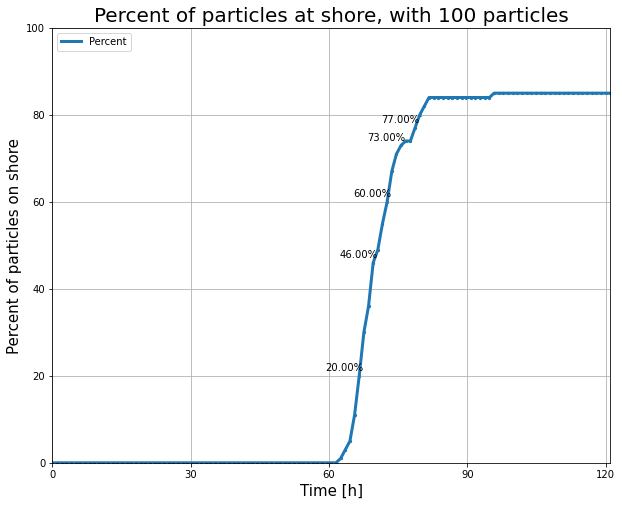

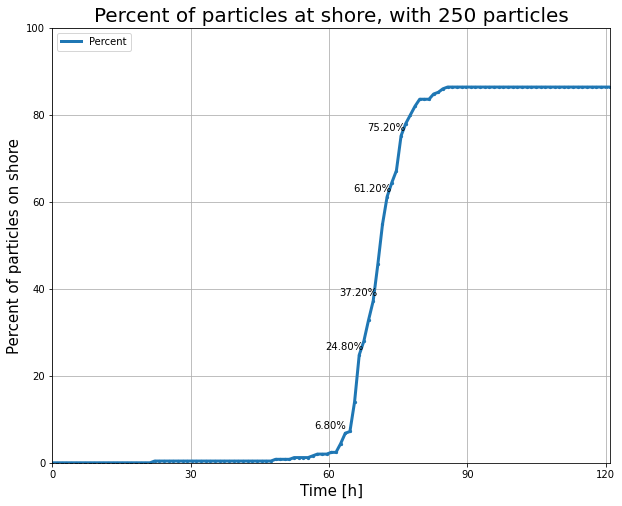

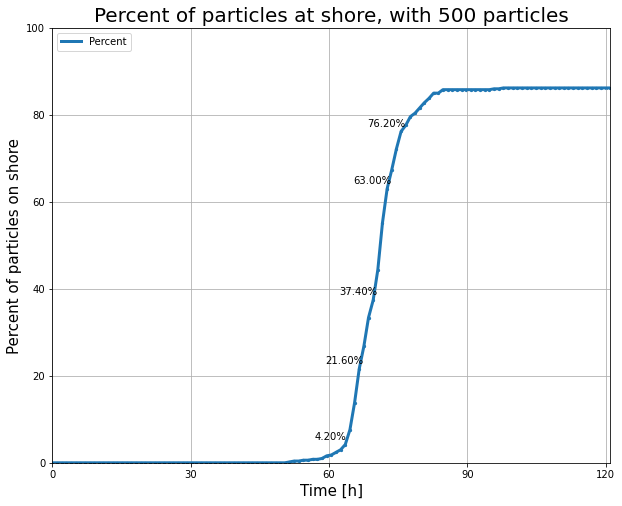

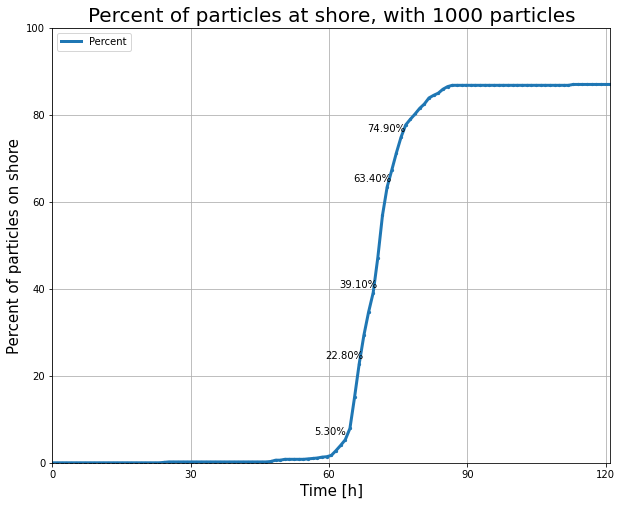

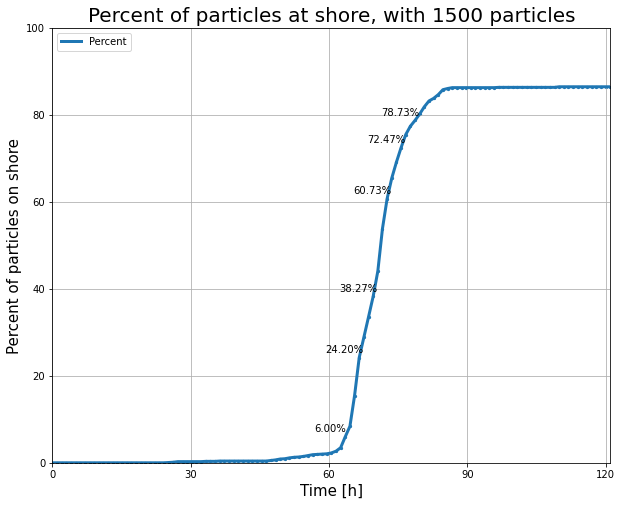

In [26]:
Nps = [100, 250, 500, 1000, 1500]
for npss in Nps:
    
    h = 3600
    days = 5
    Np = npss
    # Vestland
    f_vestland = Interpolator(dataset = d)
    X_4 = np.zeros((2, Np))
    X_4[0, :] = np.random.normal(loc=250000, scale=10000, size=Np)
    X_4[1, :] = np.random.normal(loc=460000, scale=10000, size=Np)
    posi_vestland = Heun_3(X_4, days, h, f_vestland)

    # Plotting the percentage of particles at shore over time
    fig, ax = plt.subplots(figsize=(10, 8))

    percent1 = []
    for i in range(posi_vestland.shape[0]):
        percent1.append(np.sum(f_vestland.on_land(posi_vestland[i, :, :])) * 100 / posi_vestland.shape[2])

    tid = np.linspace(0, posi_vestland.shape[0], len(percent1))
    ax.plot(tid, percent1, label='Percent', lw=3)
    ax.scatter(tid, percent1, s=5)
    for i, (x, y) in enumerate(zip(tid, percent1)):
        if percent1[i] > 4 and percent1[i] < 80 and i % 3 == 0:
            ax.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(-15, 5), ha='center')

    ax.set_title(f'Percent of particles at shore, with {npss} particles', fontsize=20)
    ax.set_aspect('auto')
    ax.set_yticks([0, 20, 40, 60, 80, 100])
    ax.set_xticks([np.min(tid), int(np.max(tid)/4), int(np.max(tid)/2), 90, np.max(tid)-1])
    ax.set_xlim(0, np.max(tid))
    ax.set_ylim(0, 100)
    ax.set_xlabel('Time [h]', fontsize=15)
    ax.set_ylabel('Percent of particles on shore', fontsize=15)
    ax.grid(True)
    ax.legend(loc=2)


I figurene over kan en se prosent av partikkler som er strandet over tid, hvor de har samme initialbetingelser, men har forskjellige antall. Som en ser fra de med 100, 250 og 500 så er det litt forskjell med hvor mye endring det er mellom hver time, da den kan svinge mye mer aggresivt enn figurene med 1000 og 1500. Ved 1000 og 1500 virker det til å bedre representere hvordan plastbiter strander over tid sammenlignet med de med lavere antall partikkler. Siden det ikke virker til å være så mye forskjell mellom 1000 og 1500, så ble det konkludert med av det var mest hensiktsmessig å bruke Np = 1000, da dette antallet gjorde beregningene representative, samt var mer hennsiktsmessig enn å ta en større verdi som f.eks 1500, da dette ville medført unødig mye kalkulasjon og kjøretid.

## b)

In [27]:
# Simulating for multiple windages, setting up the different interpolators
h = 3600
days = 3
Np = 1000
f_w = np.linspace(0,0.15, 16)
interpol = []
for i in f_w:
    interpol.append(Interpolator(dataset = d, fw = i))

# Haugesund?
X_3 = np.zeros((2,Np))
X_3[0,:] = np.random.normal(loc = 250000, scale=10000, size = Np)
X_3[1,:] = np.random.normal(loc = 460000, scale=10000, size = Np)

# Lofoten
# X_3 = np.zeros((2,Np))
# X_3[0,:] = np.random.normal(loc = 1240000, scale=10000, size = Np)
# X_3[1,:] = np.random.normal(loc = 480000, scale=10000, size = Np)

pos = []
for j in interpol:
    pos.append(Heun_3(X_3, days, h, j))

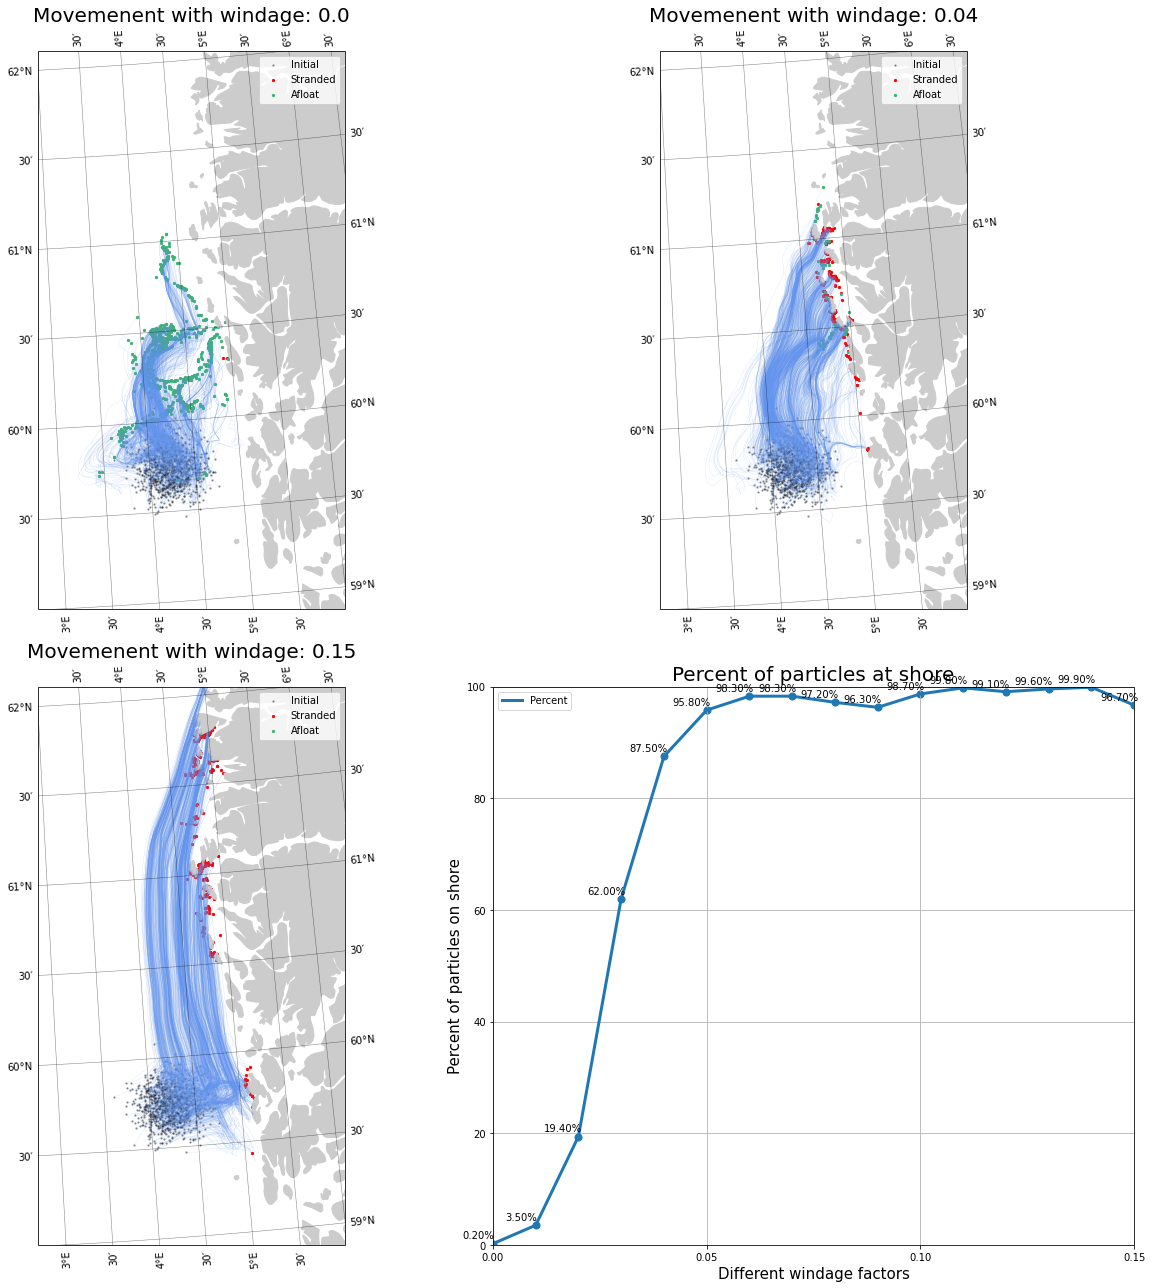

In [28]:
# Plotting some of the simulations
fig, axs = plt.subplots(2,2, figsize=(18, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})


f_w_0 = [f_w[0], f_w[4], f_w[15]]
position = [pos[0], pos[4], pos[15]]
interpoo = [interpol[0], interpol[4], interpol[15]]
for i in range(len(f_w_0)):
    
    f = interpoo[i]
    npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
    )
    axs[i // 2, i % 2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))
    axs[i // 2, i % 2].scatter(position[i][0, 0, :], position[i][0, 1, :], s=2, color = 'black', transform=npstere, label='Initial', alpha = 0.3)
    on_land = f.on_land(position[i][-1,:,:])
    axs[i // 2, i % 2].scatter(position[i][-1, 0, :]*on_land, position[i][-1, 1, :]*on_land, color = 'red', s=5, transform=npstere, label='Stranded')
    axs[i // 2, i % 2].scatter(position[i][-1, 0, :]*~on_land, position[i][-1, 1, :]*~on_land, color = 'mediumseagreen', s=5, transform=npstere, label='Afloat')
    axs[i // 2, i % 2].plot(position[i][:, 0, :], position[i][:, 1, :], transform=npstere, color = 'cornflowerblue',  alpha=0.3, lw=0.3)
    # axs[i // 2, i % 2].set_extent((3,8, 59.5, 63))
    # axs[i // 2, i % 2].set_extent((12, 16, 67,69))
    extent = axs[i // 2, i % 2].get_extent(ccrs.PlateCarree())
    axs[i // 2, i % 2].set_extent((3,6,59, 62))
    axs[i // 2, i % 2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
    axs[i // 2, i % 2].set_title(f'Movemenent with windage: {np.round(f_w_0[i],3)}', fontsize = 20)
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].set_xlabel('East', fontsize = 15)
    axs[i // 2, i % 2].set_ylabel('North', fontsize = 15)

# Percentage of particles at shore for different windages
percent = []
for i in range(len(f_w)):
    percent.append(np.sum(interpol[i].on_land(pos[i][-1,:,:]))*100/pos[i].shape[2])
axs[1,1].plot(f_w, percent, label = 'Percent', lw = 3)
axs[1,1].scatter(f_w, percent, s = 50)
for i, (x, y) in enumerate(zip(f_w, percent)):
    axs[1,1].annotate(f'{y:.2f}%', (x, y), textcoords="offset points", xytext=(-15,5), ha='center')
axs[1,1].set_title('Percent of particles at shore', fontsize = 20)
axs[1,1].set_aspect('auto') 
axs[1,1].set_xticks([0, 0.05, 0.1, 0.15])  
axs[1,1].set_yticks([0, 20, 40, 60, 80, 100])
axs[1,1].set_xlim(0, 0.15) 
axs[1,1].set_ylim(0, 100)
axs[1,1].set_xlabel('Different windage factors', fontsize = 15)
axs[1,1].set_ylabel('Percent of particles on shore', fontsize = 15)
axs[1,1].grid(True)
axs[1,1].legend(loc = 2)
plt.tight_layout()


Over kan en se tre figurer av plastikkbiter med samme initialbetingelser, men med forskjellige vind faktorer. Utifra disse figurene kan det tyde på at en høyere vind faktor vil medføre at en større andel av plastikken vil strande langs kysten, samt vil potensiellt endre hvor plastikken strandes. Om en ser på siste figur kan en se andel plastikk biter som er strandet etter 3 dager som en funksjon av vind faktoren, den virker til å bekrefte det en kunne se i de tidligere figurene, nemlig at en høyere vind faktor vil føre til at en større andel av plastikkbitene blir strandet.


 
Dersom en ser på de individuelle punktene som er "Stranded", så kan en til tider se at de ligger registrert som strandet, men på figuren er de i havet. Dette skyldes små avvik mellom koordinatene og selve kartet, etter å ha diskutert med studentassistenter har det blitt konkludert med at dette ikke har større betydning annet enn at de står stranded på et unaturlig sted på kartet. 

justify choice Np, kommenter hva prosenten betyr og hva den vil si. forklar avvik i kart. Vi må legge til i default windage, en graf av partikler som er stranded som funksjon av tid.

Usikker på dette med default windage og etter det!

konklusjon

#### Kilder
[1]: United Nations Department of Economic and Social Affairs. (n.d.). Population in Coastal Areas. Hentet  10. april 2024, fra [https://www.un.org/esa/sustdev/natlinfo/indicators/methodology_sheets/oceans_seas_coasts/pop_coastal_areas.pdf](https://www.un.org/esa/sustdev/natlinfo/indicators/methodology_sheets/oceans_seas_coasts/pop_coastal_areas.pdf)

[2]: Mathematics Department, Norwegian University of Science and Technology. (2024). Teknisk fysikk prosjekt 2024 [Technical physics project 2024]. Hentet fra https://wiki.math.ntnu.no/_media/tma4320/2024v/tekfysprosjekt_2024.pdf
